# Progseq on Bin2Cell data

In their nature paper Cell simulation as cell segmentation the authors published a method called Proseg (probabilistic segmentation), to rapidly infer morphologically plausible cell boundaries. Their benchmarking pipeline could be used for similar pourpose as we intend. Here we try to recreate the pipelines. The original code is provided in julia here https://github.com/dcjones/SpuriousCoexpression.jl/tree/main.
This script aims to reproduce the score and obtain it for various methods based on the Visium post Xenium dataset.
We will use again dataset on lung cancer tissue

use the tmp_enact_analysis environment

"Secondly, we load another segmentation: 
To produce a relative spurious coexpression distribution, we computed the conditional coexpression for each method and each pair of spuriously coexpressed genes, and then normalized (divided) by the rate observed under nuclear segmentation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

In [3]:
path_nuclei_coexpr = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/coexpr_matrix_nuc_res.npy"
path_spurious_mask = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/spurious_mask.npy"
cells_adata_path = "/srv/gstore/projects/p37785/EzPyzBin2CellApp_2025-06-29--17-56-50/Bin2CellApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cdata.h5ad"

In [4]:
# Loading Anndata object
adata_cells = sc.read_h5ad(cells_adata_path)
adata_cells

AnnData object with n_obs × n_vars = 193856 × 17959
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [5]:
sc.pp.calculate_qc_metrics(adata_cells, inplace=True)
print("Quality control metrics for cells:")
print(adata_cells.obs[['total_counts', 'n_genes_by_counts']].describe())

Quality control metrics for cells:
        total_counts  n_genes_by_counts
count  193856.000000      193856.000000
mean      129.565060          88.923397
std       144.459456         103.223098
min         0.451720           1.000000
25%        37.746815          25.000000
50%        79.297260          52.000000
75%       163.580290         109.000000
max      1927.356521        1466.000000


In [6]:

total_counts_cells = np.array(adata_cells.X.sum(axis=1)).flatten()
cell_mask_50 = total_counts_cells >= 50
filtered_ids = adata_cells.obs_names[cell_mask_50]
# Use mean_counts from AnnData var to get indices of top 1000 genes
mean_counts = adata_cells.var["mean_counts"].values
top_1000_idx = np.argsort(mean_counts)[-1000:]
# only keep the first 10000 cells for memory efficiency
adata_cells_ready = adata_cells[filtered_ids[:10000], top_1000_idx].copy()

print(f"Cells remaining after filtering for >50 transcripts: {len(filtered_ids)}")
adata_cells_ready

Cells remaining after filtering for >50 transcripts: 129048


AnnData object with n_obs × n_vars = 10000 × 1000
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial', 'spatial_cropped_150_buffer'

In [7]:

# Check for floating point precision issues in multinomial_downsample
def safe_multinomial_downsample(cdata):
    X = cdata.X.toarray() 
    X_ds = np.zeros_like(X, dtype=int)
    for i in range(X.shape[0]):
        counts = X[i]
        total = counts.sum()
        if total > 1:
            probs = counts / total
            # Normalize to sum to 1.0
            if probs.sum() > 0:
                probs = probs.astype(np.float64)  # Cast to 64-bit float
                probs = probs / probs.sum()
                X_ds[i] = np.random.multinomial(50, probs, size=1).flatten()
            else:
                print(f"Warning: Row {i} has zero total counts, skipping downsampling.")
        else:
            print(f"Warning: Row {i} has total counts {counts.sum()}<= 1, skipping downsampling.")
    return X_ds

cell_X_ds = safe_multinomial_downsample(adata_cells_ready)

# Create new AnnData objects with downsampled counts
adata_cells_resampled = anndata.AnnData(cell_X_ds, obs=adata_cells_ready.obs.copy(), var=adata_cells_ready.var.copy())

In [8]:
print("Binarizing expression matrix (cell_X_ds > 0)...")
expr = (cell_X_ds > 0).astype(int)

print("Calculating coexpression matrix using matrix multiplication...")
coexpr_matrix = (expr.T @ expr) / np.sum(expr, axis=0)

# Zero out diagonal to ignore self-coexpression
coexpr_no_diag = coexpr_matrix.copy()
np.fill_diagonal(coexpr_no_diag, 0)

# Find the indices of the top N coexpressed gene pairs
N = 10
flat_indices = np.argpartition(coexpr_no_diag.flatten(), -N)[-N:]
row_idx, col_idx = np.unravel_index(flat_indices, coexpr_no_diag.shape)

# Get gene names
gene_names = adata_cells.var_names

# List the most coexpressed gene pairs and their counts
top_pairs = []
for i, j in zip(row_idx, col_idx):
    top_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j]))

# Sort by coexpression count descending
top_pairs = sorted(top_pairs, key=lambda x: -x[2])

for g1, g2, count in top_pairs:
    print(f"{g1} - {g2}: {count}")

Binarizing expression matrix (cell_X_ds > 0)...
Calculating coexpression matrix using matrix multiplication...
ITGA10 - CASQ2: 0.9352850539291218
ITGA10 - ZNF326: 0.9350180505415162
ITGA10 - SEC22B: 0.9196141479099679
ITGA10 - KCNA2: 0.9121338912133892
ITGA10 - ANKRD35: 0.8761770244821092
ITGA10 - BCL10: 0.8584070796460177
ITGA10 - TENT5C: 0.8564814814814815
ANKRD35 - ZNF326: 0.8483754512635379
ITGA10 - PLPP3: 0.8376623376623377
NUDT17 - DNAJC8: 0.8285714285714286


In [9]:
coexpr_matrix_nuc_res = np.load(path_nuclei_coexpr)
print("Nucleus coexpression matrix shape:", coexpr_matrix_nuc_res.shape)

Nucleus coexpression matrix shape: (1000, 1000)


In [10]:
# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    rel_increase_res = coexpr_no_diag / np.where(coexpr_matrix_nuc_res > 0, coexpr_matrix_nuc_res, 1)

In [11]:
spurious_mask = np.load(path_spurious_mask)
print("Spurious mask shape:", spurious_mask.shape)

Spurious mask shape: (1000, 1000)


In [12]:
# Use the spurious_mask to extract relative coexpression values from rel_increase_res
spurious_rel_coexpr_values = rel_increase_res[spurious_mask]
print(f"Extracted {spurious_rel_coexpr_values.size} spurious relative coexpression values.")

Extracted 236020 spurious relative coexpression values.


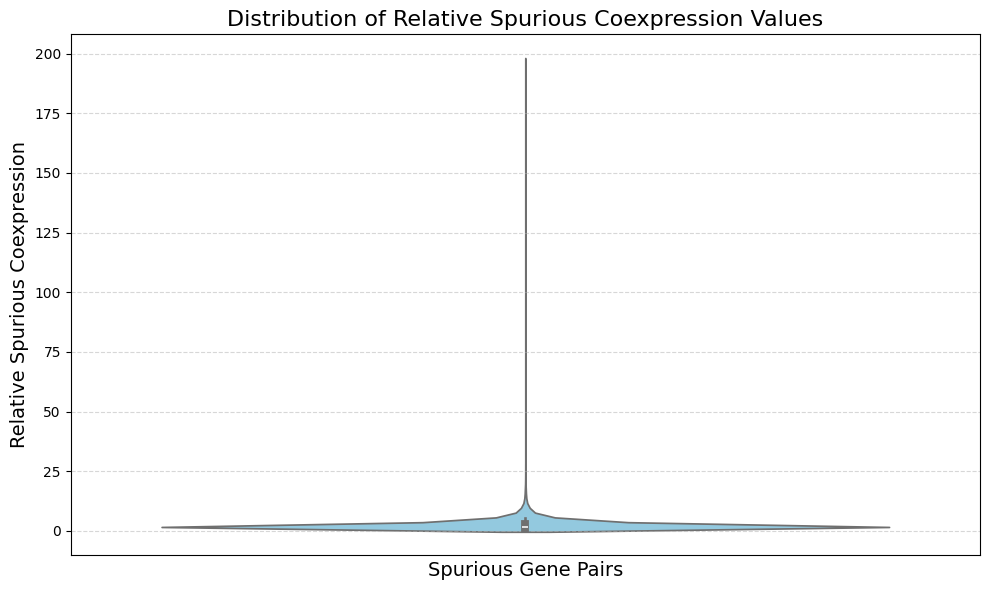

In [13]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=spurious_rel_coexpr_values, inner="box", color="skyblue")
plt.title("Distribution of Relative Spurious Coexpression Values", fontsize=16)
plt.ylabel("Relative Spurious Coexpression", fontsize=14)
plt.xlabel("Spurious Gene Pairs", fontsize=14)
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
print("Summary statistics for spurious relative coexpression values:")
print(f"Count: {spurious_rel_coexpr_values.size}")
print(f"Mean: {np.mean(spurious_rel_coexpr_values):.4f}")
print(f"Median: {np.median(spurious_rel_coexpr_values):.4f}")
print(f"Standard deviation: {np.std(spurious_rel_coexpr_values):.4f}")
print(f"Min: {np.min(spurious_rel_coexpr_values):.4f}")
print(f"Max: {np.max(spurious_rel_coexpr_values):.4f}")

Summary statistics for spurious relative coexpression values:
Count: 236020
Mean: 2.1180
Median: 1.6071
Standard deviation: 2.2144
Min: 0.0000
Max: 197.7648


In [15]:
import pandas as pd

csv_path = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/spurious_rel_coexpr.csv"
df_spurious = pd.read_csv(csv_path)
df_spurious["B2C"] = spurious_rel_coexpr_values
df_spurious.to_csv(csv_path, index=False)
print("Added 'B2C' column to CSV and saved.")

Added 'B2C' column to CSV and saved.


In [14]:
# Find pairs with >50% increase in coexpression in cells vs nuclei
spurious_mask15 = rel_increase_res > 1.5

# Get indices of such pairs
spurious_row, spurious_col = np.where(spurious_mask)

# List the pairs 
spurious_pairs = []
for i, j in zip(spurious_row, spurious_col):
    spurious_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j], coexpr_matrix_nuc_res[i, j], rel_increase_res[i, j]))

print(f"Number of potentially spurious pairs: {len(spurious_pairs)}")
# Show top 10 by relative increase
spurious_pairs_sorted = sorted(spurious_pairs, key=lambda x: -x[4])
for g1, g2, cell_val, nuc_val, rel_inc in spurious_pairs_sorted[:10]:
    print(f"{g1} - {g2}: cell={cell_val}, nuclei={nuc_val}, rel_increase={rel_inc:.2f}")

Number of potentially spurious pairs: 236020
PPM1J - ANKRD35: cell=0.04483246814535158, nuclei=0.0002249718785151856, rel_increase=199.28
RNF115 - HAO2: cell=0.5859872611464968, nuclei=0.0039946737683089215, rel_increase=146.69
DR1 - PHGDH: cell=0.07288790723357261, nuclei=0.0006693440428380187, rel_increase=108.89
INSL5 - ITGA10: cell=0.017686593562079942, nuclei=0.00017041581458759374, rel_increase=103.78
SPAG17 - MAB21L3: cell=0.19568151147098514, nuclei=0.002178649237472767, rel_increase=89.82
DR1 - PIAS3: cell=0.027535258562793822, nuclei=0.00033534540576794097, rel_increase=82.11
INSL5 - ANKRD35: cell=0.015337423312883436, nuclei=0.0002249718785151856, rel_increase=68.17
SPAG17 - CD53: cell=0.14545454545454545, nuclei=0.0022371364653243847, rel_increase=65.02
DR1 - HMGCS2: cell=0.03556485355648536, nuclei=0.0005491488193300384, rel_increase=64.76
INKA2 - ADAM30: cell=0.07202039515615041, nuclei=0.0011217049915872126, rel_increase=64.21
